https://medium.com/saturdays-ai/web-scraping-para-machine-learning-71f7e673bcf3

# <center> Coches de segunda mano en Murcia

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling  as pd_eda
from tqdm import tqdm_notebook as tqdm

import requests
from bs4 import BeautifulSoup

%matplotlib inline
sns.set()

# 1. Seleccionar página web

- [mobile.de](https://www.mobile.de/es/): Europa, mas ordenado
- Autoscout
- Coches.net
- [Milanuncios](https://www.milanuncios.com/coches-de-segunda-mano-en-murcia/?hasta=10000&demanda=n&anod=2010) (coches murcia)
  - Hasta 10000 euros
  - Desde el 2010

# 2. Extraer datos (web scrapping)
### Hay 30 coches por página

Cada `<div class="aditem">...</div>` es una **anuncio de un coche**. Y tiene:
- **Título**: `<div class="aditem-detail-title">`
- **Precio**: `<div class="aditem-price">`
- **Año**: `<div class="ano">`
- **Kms**: `<div class="kms">`
- **Cindrada**: `<div class="cc">`
- **Vendedor**: `<div class="pillSellerTypePro">`
- **Cambio**: `cmanual` o `cauto`

### Otros campos interesantes
- **Fecha de publicación** -> Series temporales
- **Imágenes** -> Computer vision
- **Descripción** -> NLP

In [2]:
def getDiv(className, component="div"):
    if anuncio.find(component, class_=className):
        return anuncio.find(component, class_=className).get_text()
    else:
        return None

In [3]:
def getBinary(className1, className2, component="div"):
    if anuncio.find(component, class_=className1):
        return anuncio.find(component, class_=className1).get_text()
    elif anuncio.find(component, class_=className2):
        return anuncio.find(component, class_=className2).get_text()
    else:
        return None

In [4]:
#url    = "https://www.milanuncios.com/coches-de-segunda-mano-en-murcia/?hasta=10000&demanda=n&anod=2010&pagina="
url     = "https://www.milanuncios.com/coches-de-segunda-mano-en-murcia/?demanda=n&pagina="
paginas = 100

data = []

for pagina in tqdm(range(1,paginas+1)):
    page = requests.get(url+str(pagina))    
    soup = BeautifulSoup(page.content, 'html.parser')
    anuncios = soup.find_all('div', class_='aditem')
    
    for anuncio in anuncios:
        titulo = getDiv('aditem-detail-title', component="a")
        marca  = titulo.split(" - ")[0]
        modelo = titulo.split(" - ")[1]
        precio = getDiv('aditem-price')
        ano    = getDiv('ano')
        kms    = getDiv('kms')
        cc     = getDiv('cc')
        puertas = getDiv('ejes')
        cambio = getBinary("cmanual", "cauto")
        vendedor    = getBinary("pillSellerTypePro", "pillSellerTypePriv")
        combustible = getBinary("die", "gas")
        data.append([marca, modelo, precio, ano, kms, cambio, cc, puertas, vendedor, combustible])

df = pd.DataFrame(data=data, columns=("Marca",
                                      "Modelo",
                                      "Precio",
                                      "Año",
                                      "Kms",
                                      "Cambio",
                                      "Cc",
                                      "Puertas",
                                      "Vendedor",
                                      "Combust"))
df[["Marca", "Precio", "Año", "Kms", "Cambio", "Cc", "Puertas", "Vendedor", "Combust"]]

,Marca,Precio,Año,Kms,Cambio,Cc,Puertas,Vendedor,Combust
0,VOLKSWAGEN,29.250€,año 2018,16.900 kms,automat,150 cv,5 puertas,Profesional,diesel
1,VOLKSWAGEN,20.990€,año 2016,129.000 kms,automat,220 cv,5 puertas,Profesional,gasolina
2,LAND-ROVER,71.000€,año 2019,8.100 kms,automat,249 cv,5 puertas,Profesional,diesel
3,MERCEDES-BENZ,92.000€,año 2017,13.000 kms,automat,455 cv,2 puertas,Profesional,gasolina
4,MITSUBISHI,12.500€,año 2012,112.000 kms,manual,150 cv,5 puertas,Profesional,diesel
...,...,...,...,...,...,...,...,...,...
1165,HYUNDAI,250€,año 1999,40.000 kms,manual,1 cv,5 puertas,Particular,gasolina
1166,BMW,300€,año 2015,2 kms,manual,2 cv,5 puertas,Particular,diesel
1167,OPEL,1.200€,año 2000,225.000 kms,manual,None,5 puertas,Particular,diesel
1168,OPEL,3.790€,año 2006,254.000 kms,manual,170 cv,3 puertas,Particular,gasolina


# Data Cleaning

In [5]:
df["Precio_clean"]  = df["Precio"].str.split('€').str[0].replace("\.", "", regex=True)
df["Año_clean"]     = df["Año"].replace("año ", "", regex=True)
df["Kms_clean"]     = df["Kms"].replace(" kms", "", regex=True).replace("\.", "", regex=True)
df["Puertas_clean"] = df["Puertas"].replace(" puertas", "", regex=True)
df["Cc_clean"]      = df["Cc"].replace(" cv", "", regex=True)

In [6]:
df.head()

,Marca,Modelo,Precio,Año,Kms,Cambio,Cc,Puertas,Vendedor,Combust,Precio_clean,Año_clean,Kms_clean,Puertas_clean,Cc_clean
0,VOLKSWAGEN,ARTEON 2. 0 TDI R-LINE DSG,29.250€,año 2018,16.900 kms,automat,150 cv,5 puertas,Profesional,diesel,29250,2018,16900,5,150
1,VOLKSWAGEN,GTI DSG MK7 PERFOMANCE BLAK,20.990€,año 2016,129.000 kms,automat,220 cv,5 puertas,Profesional,gasolina,20990,2016,129000,5,220
2,LAND-ROVER,RANGE ROVER SPORT 3. 0 SDV6 183KW 249CV SE,71.000€,año 2019,8.100 kms,automat,249 cv,5 puertas,Profesional,diesel,71000,2019,8100,5,249
3,MERCEDES-BENZ,CLASE S S 500 CABRIO,92.000€,año 2017,13.000 kms,automat,455 cv,2 puertas,Profesional,gasolina,92000,2017,13000,2,455
4,MITSUBISHI,OUTLANDER 220 DID MOTION 4WD,12.500€,año 2012,112.000 kms,manual,150 cv,5 puertas,Profesional,diesel,12500,2012,112000,5,150


In [7]:
df["Precio_clean"]  = pd.to_numeric(df["Precio_clean"])
df["Año_clean"]     = pd.to_numeric(df["Año_clean"])
df["Kms_clean"]     = pd.to_numeric(df["Kms_clean"])
df["Puertas_clean"] = pd.to_numeric(df["Puertas_clean"])
df["Cc_clean"]      = pd.to_numeric(df["Cc_clean"])

In [8]:
df.head()

,Marca,Modelo,Precio,Año,Kms,Cambio,Cc,Puertas,Vendedor,Combust,Precio_clean,Año_clean,Kms_clean,Puertas_clean,Cc_clean
0,VOLKSWAGEN,ARTEON 2. 0 TDI R-LINE DSG,29.250€,año 2018,16.900 kms,automat,150 cv,5 puertas,Profesional,diesel,29250.0,2018.0,16900.0,5.0,150.0
1,VOLKSWAGEN,GTI DSG MK7 PERFOMANCE BLAK,20.990€,año 2016,129.000 kms,automat,220 cv,5 puertas,Profesional,gasolina,20990.0,2016.0,129000.0,5.0,220.0
2,LAND-ROVER,RANGE ROVER SPORT 3. 0 SDV6 183KW 249CV SE,71.000€,año 2019,8.100 kms,automat,249 cv,5 puertas,Profesional,diesel,71000.0,2019.0,8100.0,5.0,249.0
3,MERCEDES-BENZ,CLASE S S 500 CABRIO,92.000€,año 2017,13.000 kms,automat,455 cv,2 puertas,Profesional,gasolina,92000.0,2017.0,13000.0,2.0,455.0
4,MITSUBISHI,OUTLANDER 220 DID MOTION 4WD,12.500€,año 2012,112.000 kms,manual,150 cv,5 puertas,Profesional,diesel,12500.0,2012.0,112000.0,5.0,150.0


# Exploratory Data Analysis

In [30]:
def plot_num(variable, title="", min=False, max=False, zeros=True, size=(16,4)):
    if not zeros:
        variable=variable[variable!=0]
        title += " (no zeros)"
    if min:
        variable = variable[variable >= min]
        title += " (min: "+str(min)+")"
    if max:
        variable = variable[variable <= max]
        title += " (max: "+str(max)+")"
    plt.figure(figsize=size)
    sns.violinplot(variable, cut=0, palette="Set3", inner="quart" )
    sns.stripplot(variable, color="grey", alpha=.5).set_title(title, fontsize=20);
    
# Variables ordinales
def plot_ord(variable, title="", min=False, max=False, zeros=True, size=(16,4)):
    if not zeros:
        variable=variable[variable!=0]
        title += " (no zeros)"
    if min:
        variable = variable[variable >= min]
        title += " (min: "+str(min)+")"
    if max:
        variable = variable[variable <= max]
        title += " (max: "+str(max)+")"
    plt.figure(figsize=size)
    sns.countplot(variable, color='royalblue').set_title(title, fontsize=20);
    
# Variables categoricas
def plot_cat(variable, title="", top=False, normalize=False, dropna=False, size=(16,4)):
    plt.figure(figsize=size)
    cats = variable.value_counts(normalize=normalize, dropna=dropna)
    if top:
        cats = cats[:top]
        title += " (top "+str(top)+")"
    sns.barplot(x=cats, y=cats.index).set_title(title, fontsize=20);

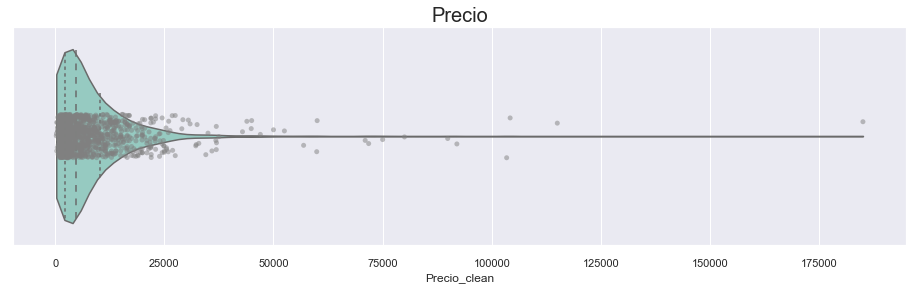

In [31]:
plot_num(df.Precio_clean, "Precio")

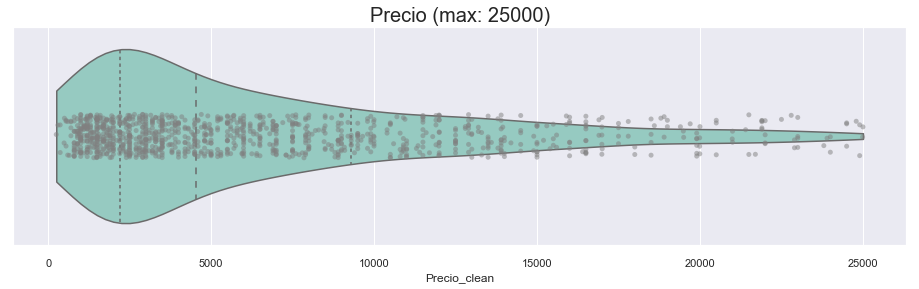

In [32]:
plot_num(df.Precio_clean, "Precio", max=25000)

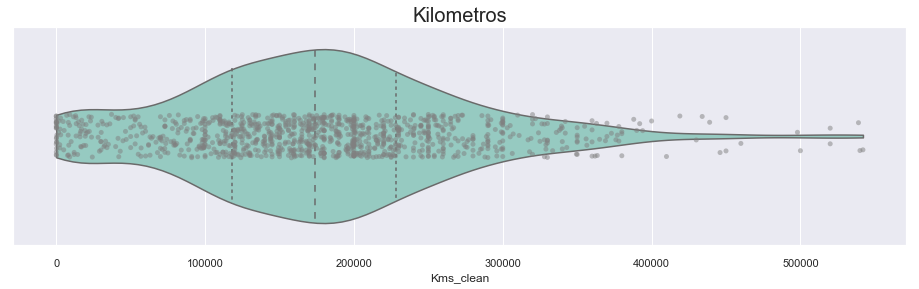

In [33]:
plot_num(df.Kms_clean, "Kilometros")

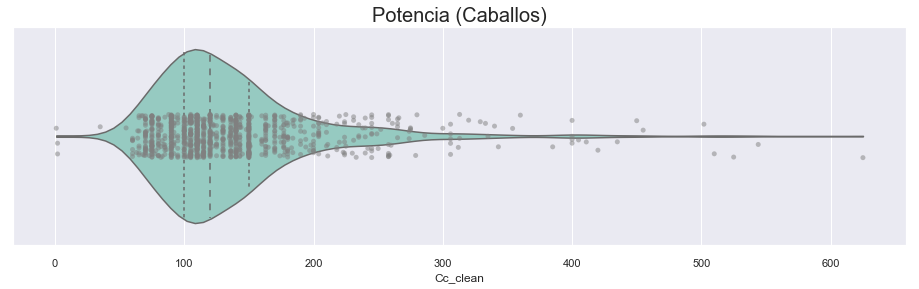

In [44]:
plot_num(df.Cc_clean, "Potencia (Caballos)")

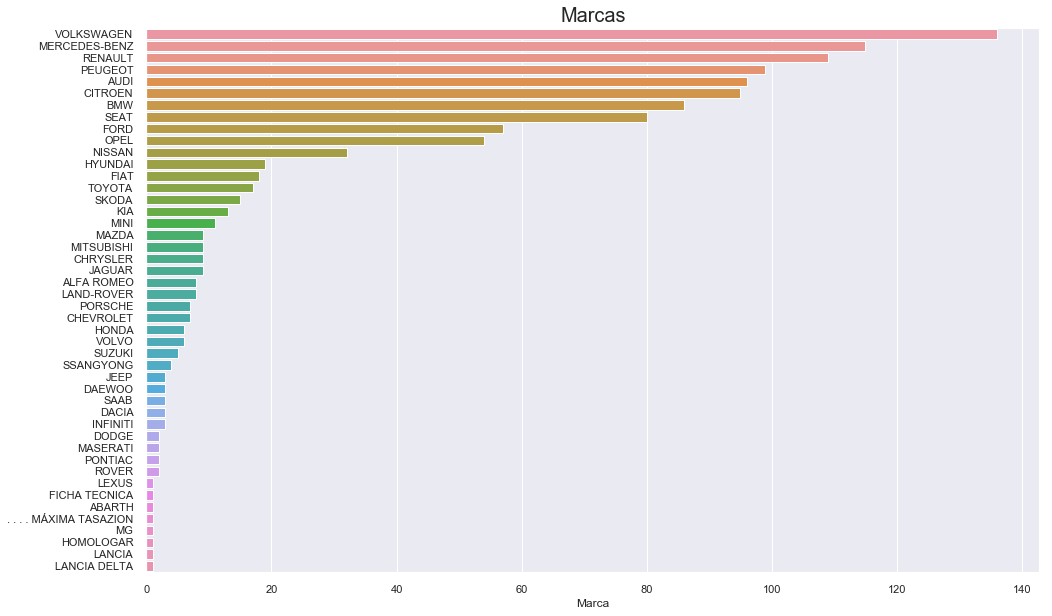

In [46]:
plot_cat(df.Marca, "Marcas", size=(16,10))

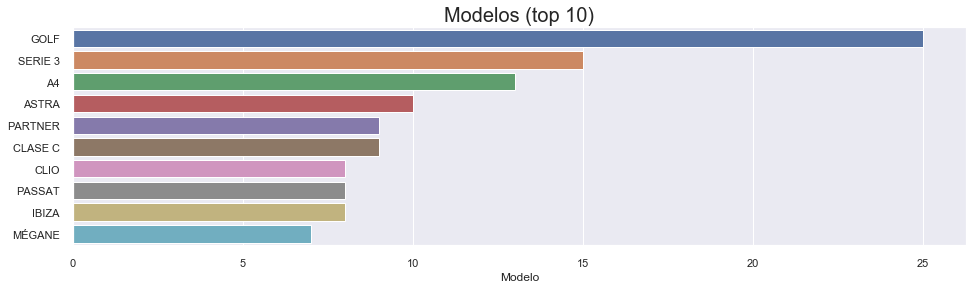

In [47]:
plot_cat(df.Modelo, "Modelos", top=10)

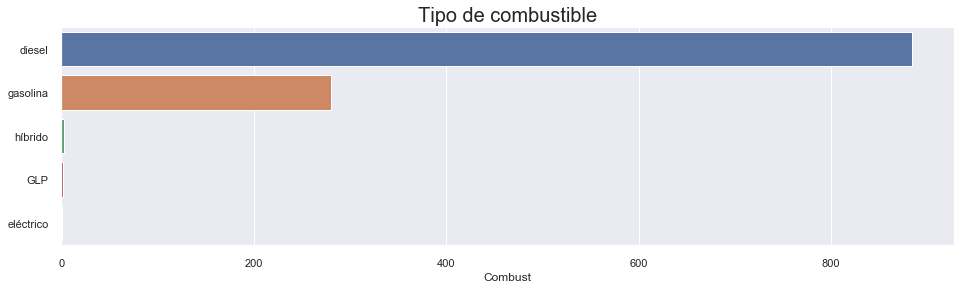

In [36]:
plot_cat(df.Combust, "Tipo de combustible")

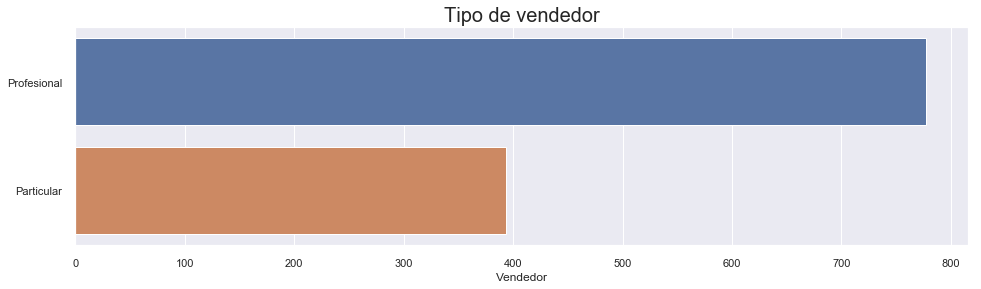

In [37]:
plot_cat(df.Vendedor, "Tipo de vendedor")

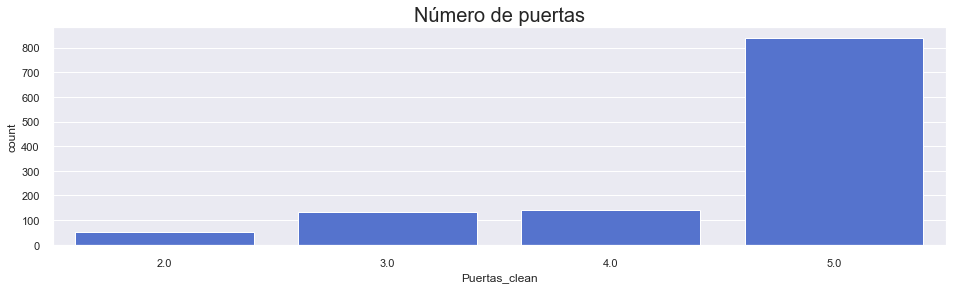

In [38]:
plot_ord(df.Puertas_clean, "Número de puertas")

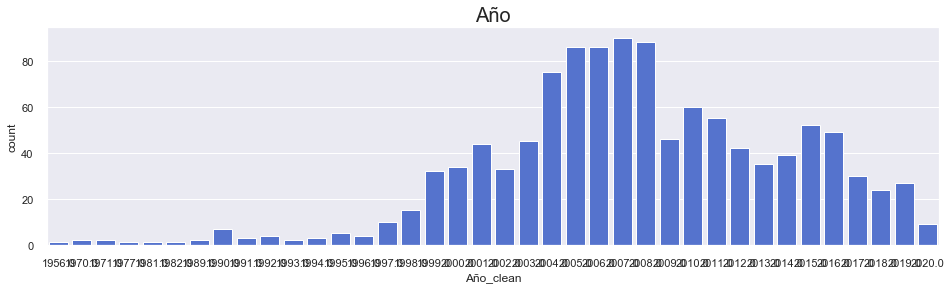

In [39]:
plot_ord(df.Año_clean, "Año")

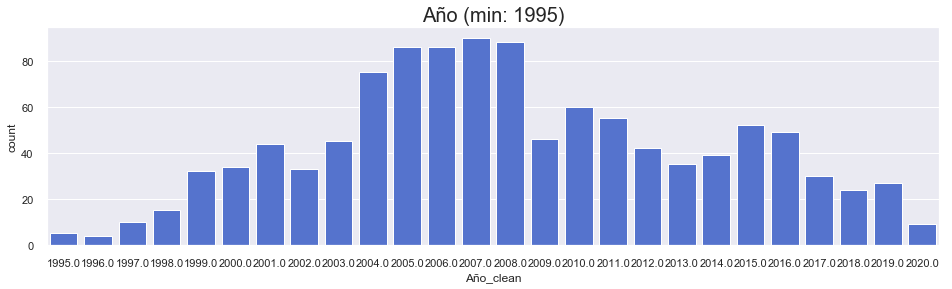

In [43]:
plot_ord(df.Año_clean, "Año", min=1995)

# Categorical encoging
- Label encoding marca
- Label encoding marca + modelo
- One-hot encoding

# Train Model with target: price

# Predict price for every car

# Compute how good is the price (percentage)